<a href="https://colab.research.google.com/github/ce3tnia/DeepLearning/blob/master/CocoaBeans_ResNeXt101_70%3A30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pickle
import pandas as pd

import cv2
import keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
import os, random, time
from os import listdir
from keras import backend as K
from keras.layers import Input, Activation, Add, AveragePooling2D, BatchNormalization, Concatenate, Lambda, ZeroPadding2D
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [ ]:
epochs = 100
init_lr = 1e-3
batch_sizes = 4
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "/content/drive/MyDrive/dataset/cocoa beans"
size = 256
input_sizes = (size,size,3)

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir) 
        if image is not None :
            image = cv2.resize(image, default_image_size)  
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:105]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Whole_Beans_Cocoa ...
[INFO] Processing Bean_Fraction_Cocoa ...
[INFO] Processing Broken_Beans_Cocoa ...
[INFO] Processing Fermented_Cocoa ...
[INFO] Processing Moldy_Cocoa ...
[INFO] Processing Unfermented_Cocoa ...
[INFO] Image loading completed
CPU times: user 73 µs, sys: 21 µs, total: 94 µs
Wall time: 97.5 µs


In [ ]:
image_size = len(image_list)
print(image_size)

614


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Bean_Fraction_Cocoa' 'Broken_Beans_Cocoa' 'Fermented_Cocoa'
 'Moldy_Cocoa' 'Unfermented_Cocoa' 'Whole_Beans_Cocoa']


In [ ]:
print(n_classes)

6


In [ ]:
#rescale
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.3, random_state = 42)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True, 
    fill_mode="nearest")

# **Arsitektur ResNeXt101**

In [ ]:
def split(inputs, cardinality):
    inputs_channels = inputs.shape[3]
    group_size = inputs_channels // cardinality    
    groups = list()
    for number in range(1, cardinality+1):
        begin = int((number-1)*group_size)
        end = int(number*group_size)
        block = Lambda(lambda x:x[:,:,:,begin:end])(inputs)
        groups.append(block)
    return groups

In [ ]:
def transform(groups, filters, strides, stage, block):
    f1, f2 = filters    
    conv_name = "conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    transformed_tensor = list()
    i = 1
    
    for inputs in groups:
        # first conv of the transformation phase
        x = Conv2D(filters=f1, kernel_size=(1,1), strides=strides, padding="valid", 
                   name=conv_name+'1a_split'+str(i), kernel_initializer=glorot_uniform(seed=0))(inputs)
        x = BatchNormalization(axis=3, name=bn_name+'1a_split'+str(i))(x)
        x = Activation('relu')(x)

        # second conv of the transformation phase
        x = Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding="same", 
                   name=conv_name+'1b_split'+str(i), kernel_initializer=glorot_uniform(seed=0))(x)
        x = BatchNormalization(axis=3, name=bn_name+'1b_split'+str(i))(x)
        x = Activation('relu')(x)
        
        # Add x to transformed tensor list
        transformed_tensor.append(x)
        i+=1
        
    # Concatenate all tensor from each group
    x = Concatenate(name='concat'+str(stage)+''+block)(transformed_tensor)
    
    return x

In [ ]:
def transition(inputs, filters, stage, block):
    x = Conv2D(filters=filters, kernel_size=(1,1), strides=(1,1), padding="valid", 
                   name='conv2d-trans'+str(stage)+''+block, kernel_initializer=glorot_uniform(seed=0))(inputs)
    x = BatchNormalization(axis=3, name='batchnorm-trans'+str(stage)+''+block)(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def identity_block(inputs, filters, cardinality, stage, block, strides=(1,1)):
    
    conv_name = "conv2d-{stage}{block}-branch".format(stage=str(stage),block=str(block))
    bn_name = "batchnorm-{stage}{block}-branch".format(stage=str(stage),block=str(block))
    
    #save the input tensor value
    x_shortcut = inputs
    x = inputs
    
    f1, f2, f3 = filters
    
    # divide input channels into groups. The number of groups is define by cardinality param
    groups = split(inputs=x, cardinality=cardinality)
    
    # transform each group by doing a set of convolutions and concat the results
    f1 = int(f1 / cardinality)
    f2 = int(f2 / cardinality)
    x = transform(groups=groups, filters=(f1, f2), strides=strides, stage=stage, block=block)
    
    # make a transition by doing 1x1 conv
    x = transition(inputs=x, filters=f3, stage=stage, block=block)
    
    # Last step of the identity block, shortcut concatenation
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [ ]:
def downsampling(inputs, filters, cardinality, strides, stage, block):
    
    # useful variables
    conv_name = "conv2d-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    bn_name = "batchnorm-{stage}{block}-branch".format(stage=str(stage), block=str(block))
    
    # Retrieve filters for each layer
    f1, f2, f3 = filters
    
    # save the input tensor value
    x_shortcut = inputs
    x = inputs
    
    # divide input channels into groups. The number of groups is define by cardinality param
    groups = split(inputs=x, cardinality=cardinality)
    
    # transform each group by doing a set of convolutions and concat the results
    f1 = int(f1 / cardinality)
    f2 = int(f2 / cardinality)
    x = transform(groups=groups, filters=(f1, f2), strides=strides, stage=stage, block=block)
    
    # make a transition by doing 1x1 conv
    x = transition(inputs=x, filters=f3, stage=stage, block=block)
    
    # Projection Shortcut to match dimensions 
    x_shortcut = Conv2D(filters=f3, kernel_size=(1,1), strides=strides, padding="valid", 
               name='{base}2'.format(base=conv_name), kernel_initializer=glorot_uniform(seed=0))(x_shortcut)
    x_shortcut = BatchNormalization(axis=3, name='{base}2'.format(base=bn_name))(x_shortcut)
    
    # Add x and x_shortcut
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [ ]:
def ResNeXt101(input_shape, classes):
    
    # Transform input to a tensor of shape input_shape 
    x_input = Input(input_shape)
    
    # Add zero padding
    x = ZeroPadding2D((3,3))(x_input)
    
    # Initial Stage. Let's say stage 1
    x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), 
               name='conv2d_1', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name='batchnorm_1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2))(x)
    
    # Stage 2
    x = downsampling(inputs=x, filters=(64,64,256), cardinality=4, strides=(2,2), stage=2, block="a")
    x = identity_block(inputs=x, filters=(64,64,256), cardinality=4, stage=2, block="b")
    x = identity_block(inputs=x, filters=(64,64,256), cardinality=4, stage=2, block="c")
    
    
    # Stage 3
    x = downsampling(inputs=x, filters=(32,32,512), cardinality=4, strides=(2,2), stage=3, block="a")
    x = identity_block(inputs=x, filters=(32,32,512), cardinality=4, stage=3, block="b")
    x = identity_block(inputs=x, filters=(32,32,512), cardinality=4, stage=3, block="c")
    x = identity_block(inputs=x, filters=(32,32,512), cardinality=4, stage=3, block="d")
    
    
    # Stage 4
    x = downsampling(inputs=x, filters=(16,16,1024), cardinality=4, strides=(2,2), stage=4, block="a")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="b")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="c")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="d")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="e")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="f")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="g")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="h")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="i")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="j")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="k")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="l")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="m")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="n")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="o")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="p")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="q")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="r")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="s")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="t")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="u")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="v")
    x = identity_block(inputs=x, filters=(16,16,1024), cardinality=4, stage=4, block="w")
    
    
    # Stage 5
    x = downsampling(inputs=x, filters=(8,8,2048), cardinality=4, strides=(2,2), stage=5, block="a")
    x = identity_block(inputs=x, filters=(8,8,2048), cardinality=4, stage=5, block="b")
    x = identity_block(inputs=x, filters=(8,8,2048), cardinality=4, stage=5, block="c")
    
    
    # Average pooling
    x = AveragePooling2D(pool_size=(2,2), padding="same")(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(classes, activation="softmax", kernel_initializer=glorot_uniform(seed=0), 
              name="fc{cls}".format(cls=str(classes)))(x)
    
    # Create the model
    model = Model(inputs=x_input, outputs=x, name="resnext101")
    
    return model

In [ ]:
model = ResNeXt101(input_shape=input_sizes, classes=n_classes)

In [ ]:
model.summary()

Model: "resnext101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 128, 128, 64) 256         conv2d_1[0][0]                   
_________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.769269 to fit
tcmalloc: large alloc 1829978112 bytes == 0x558158802000 @  0x7fc53cbaf001 0x7fc538e461fa 0x7fc538e462ad 0x7fc539fd16df 0x7fc53a4c8261 0x7fc53c945468 0x7fc53c947d53 0x558155892092 0x7fc53c2fabf7 0x55815589212a



In [ ]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') >= 0.92):
      print("\n\akurasi telah mencapai lebih dari 92% dan akurasi validasi telah mencapai 0.92")
      self.model.stop_training = True

stopProcess = Callback()

In [ ]:
opt = Adam(lr=init_lr, decay=init_lr / epochs)
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_sizes), 
    steps_per_epoch=int(len(x_train) // batch_sizes),  
    validation_data = (x_test, y_test), 
    epochs=epochs, verbose=1, callbacks = [stopProcess])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
107/107 [==============================] - 53s 193ms/step - loss: 7.8616 - accuracy: 0.2255 - val_loss: 3.9704 - val_accuracy: 0.1568
Epoch 2/100
107/107 [==============================] - 14s 133ms/step - loss: 4.8008 - accuracy: 0.2707 - val_loss: 3.5684 - val_accuracy: 0.1568
Epoch 3/100
107/107 [==============================] - 14s 134ms/step - loss: 2.7433 - accuracy: 0.3887 - val_loss: 3.4064 - val_accuracy: 0.2270
Epoch 4/100
107/107 [==============================] - 14s 133ms/step - loss: 2.6349 - accuracy: 0.3239 - val_loss: 1.7779 - val_accuracy: 0.3405
Epoch 5/100
107/107 [==============================] - 14s 132ms/step - loss: 2.0046 - accuracy: 0.3804 - val_loss: 1.6241 - val_accuracy: 0.4324
Epoch 6/100
107/107 [==============================] - 14s 132ms/step - loss: 1.9725 - accuracy: 0.4540 - val_loss: 2.1592 - val_accuracy: 0.3676
Epoch 7/100
107/107 [==============================] - 14s 133ms/step - loss: 1.9329 - accuracy: 0.3707 - val_loss: 2.5623 -

In [ ]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

6/6 [==============================] - 0s 54ms/step - loss: 0.8299 - accuracy: 0.6541
Test Accuracy: 65.4054045677185


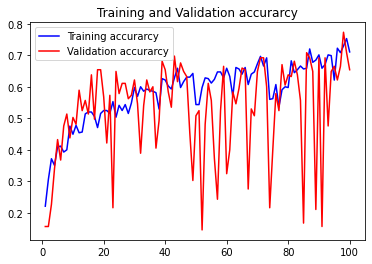

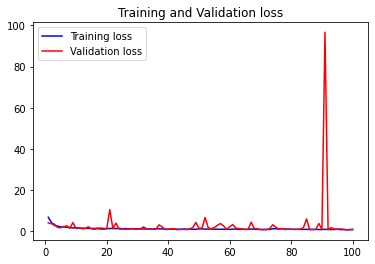

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
model_pred = model.predict(x_test, batch_sizes, verbose=2)
model_predicted = np.argmax(model_pred, axis=1)

47/47 - 6s


In [ ]:
model_resnext101 = confusion_matrix(np.argmax(y_test, axis=1), model_predicted)

np.set_printoptions(precision=2)
print(model_resnext101)
plt.figure()

[[29  0  0  0  0  0]
 [ 0 26  1  2  2  0]
 [ 0  4 17  2  3  0]
 [ 0 13  2 15  0  0]
 [ 0  4  4  0 22  0]
 [ 0  0  1  0  0 38]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

[Text(0, 0.5, 'Bean_Fraction_Cocoa'),
 Text(0, 1.5, 'Broken_Beans_Cocoa'),
 Text(0, 2.5, 'Fermented_Cocoa'),
 Text(0, 3.5, 'Moldy_Cocoa'),
 Text(0, 4.5, 'Unfermented_Cocoa'),
 Text(0, 5.5, 'Whole_Beans_Cocoa')]

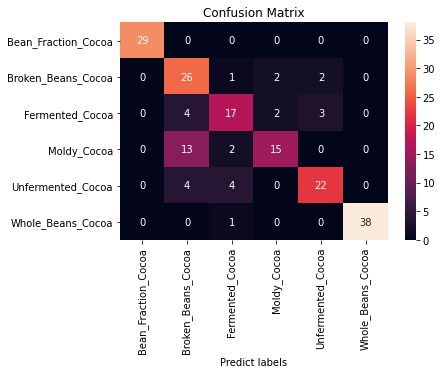

In [ ]:
import seaborn as sns

ax = plt.subplot()
sns.heatmap(model_resnext101, annot= True, ax = ax)

ax.set_xlabel('Predict labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_binarizer.classes_, rotation=90)
ax.yaxis.set_ticklabels(label_binarizer.classes_, rotation=0)

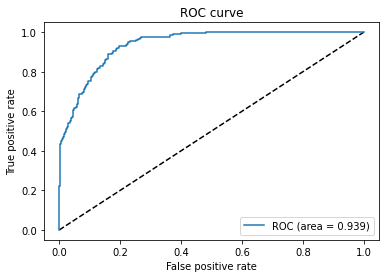

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), model_pred.ravel())
auc_ = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (area = {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
print(len(x_test))

185


In [ ]:
print(label_binarizer.classes_)

['Bean_Fraction_Cocoa' 'Broken_Beans_Cocoa' 'Fermented_Cocoa'
 'Moldy_Cocoa' 'Unfermented_Cocoa' 'Whole_Beans_Cocoa']


In [ ]:
class_to_label_map={ 0:'Bean_Fraction_Cocoa', 1:'Broken_Beans_Cocoa', 2:'Fermented_Cocoa', 3:'Moldy_Cocoa', 4:'Unfermented_Cocoa', 5:'Whole_Beans_Cocoa'}

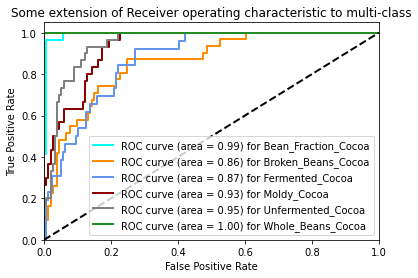

In [ ]:
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'grey', 'forestgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    i=i+1
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()